In [1]:
#default_exp utils

In [2]:
#hide
from nbdev.showdoc import *

In [3]:
#hide
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [4]:
#export 
import copy
from tqdm.notebook import tqdm
#linalg
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.fixes import _joblib_parallel_args
from joblib import Parallel, delayed

import scipy

try:
    from sparse_dot_topn import awesome_cossim_topn
except ImportError as e:
    warn(f"{e}")
    warn("sparse_dot_topn module not installed, will use naive dot product for vector query. This may lead to memory overload")

# data and viz
from sklearn.datasets import make_regression
import seaborn as sns
import matplotlib.pyplot as plt

# Helping Functions - 

In [5]:
#export
#auxiliary functions
def ctqdm(iterable, verbose = False, notebook = False,**tqdm_kwargs):
    '''
    progress bar handler (custom tqdm)
    '''
    if not verbose:
        return iterable
    else:
        if notebook:
            return tqdm.notebook.tqdm(iterable,**tqdm_kwargs)
        else:
            return tqdm.tqdm(iterable,**tqdm_kwargs)

## Shape functions

In [6]:
#export
#shape fixing functions
def _add_n_dists_axis(X):
    '''
    when the array represents a single dist of shape (n_samples, n_dims),
    returns a 3 axis representation (1[n_dists], n_samples, n_dims)
    '''
    try:
        _assert_dim_3d(X)
        return X
    except:
        _assert_dim_2d(X)
        return X.reshape(1, *X.shape)

def _add_n_samples_axis(X):
    '''
    when the array represents a single sample dists of shape (n_dists, n_dims),
    returns a 3 axis representation (n_dists, 1[n_samples], n_dims)
    '''
    try:
        _assert_dim_3d(X)
        return X
    except:
        _assert_dim_2d(X)
        return X.reshape(X.shape[0], 1, X.shape[1])

def _add_n_dims_axis(X):
    '''
    when the array represents a single dim of shape (n_dists ,n_samples,),
    returns a 3 axis representation (n_dists, n_samples, 1[n_dims])
    '''
    try:
        _assert_dim_3d(X)
        return X
    except:
        _assert_dim_2d(X)
        return X.reshape(*X.shape, 1)

# some alaises of above functions may be lsited below
def _fix_one_sample_2d(X):
    '''
    returns a 3d array of shape (n_samples, 1, n_dims)
    given an array of shape (n_samples, n_dims)
    '''
    try: return _assert_dim_3d(X)
    except: return X.reshape(X.shape[0], 1, X.shape[1])

def _fix_one_dist_2d(X):
    '''
    returns a one distributiton 3d array of shape (1,n_sample_per_distribution,n_dims)
    given an array of shape (n_sample_per_distribution,n_dims)
    '''
    try: return _assert_dim_3d(X)
    except: return X.reshape(1, X.shape[0], X.shape[1])

def _fix_dist_1d(X):
    '''
    returns a one dimension dist 3d array of shape (n_distributions, n_sample_per_distribution, 1)
    given an array of shape (n_distributions, n_sample_per_distribution)
    '''
    try: return _assert_dim_3d(X)
    except: return X.reshape(X.shape[0], X.shape[1], 1)

def _fix_one_dist_1d(X):
    '''
    returns a one dimension dist 3d array of shape (1, n_sample_per_distribution, 1)
    given an array of shape (n_sample_per_distribution,)
    '''
    try: return _assert_dim_3d(X)
    except: return X.reshape(1, X.shape[0], 1)

def _vector_1d_to_matrix(X):
    '''Makes 1d array a 2d column matrix'''
    #X = np.array(X)
    #reshape if shape == (n_samples,)
    X = X if len(X.shape) > 1 else X.reshape(-1,1)
    return X

def _fix_X_1d(X):
    '''Makes 1d array a 2d one'''
    #X = np.array(X)
    #reshape if shape == (n_samples,)
    X = X if len(X.shape) > 1 else X.reshape(-1,1)
    return X

def _assert_dim_3d(X):
    '''
    usefull for distribution arrays of shape (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion)
    '''
    assert len(X.shape) == 3, f'X must have 3 dimensions: (n_distributions, n_sample_per_distribution, n_dims_in_distribtuion). got {X.shape} insted'
    return X

def _assert_dim_2d(X):
    '''
    assert ana rray have 2 dim
    '''
    assert len(X.shape) == 2, f'X must have 2 dimensions. got {X.shape} instead'
    return X

def _assert_dim_1d(X):
    '''
    assert array has 1dim
    '''
    assert len(X.shape) == 1, f'X must have 1 dimension. got {X.shape} instead'
    return X

def pad_to_shape(array, shape):
    '''fill array with trilling zeros to match shape'''
    arr = np.zeros(shape)
    arr[tuple(slice(0,i) for i in array.shape)] = array
    return arr

def fix_samples_shape(samples):
    '''
    if shape == (n_samples,), return (1[n_dists], n_samples, 1[n_dims])
    if shape == (n_samples, n_dims), return (1[n_dists], n_samples, n_dims)
    if shape == (n_dists, n_samples, n_dims) , return same  array

    if n_dims > 3, raise AssertionError
    '''
    assert len(samples.shape) <= 3, 'Samples array should be at max 3dim (n_dists, n_samples, n_dims)'
    if len(samples.shape) == 1:
        return  samples.reshape(1, samples.shape[0],1)
    elif len(samples.shape) == 2:
        return  samples.reshape(1, samples.shape[0],samples.shape[0])
    else:
        return samples

## Sample functions

In [7]:
#export
def count_unique_by_row(a):
    '''
    returns the counts of each element per row
    usefull when sampling index matrix and returning the counts for each index in each row
    '''
    weight = 1j*np.linspace(0, a.shape[1], a.shape[0], endpoint=False)
    b = a + weight[:, np.newaxis]
    u, ind, cnt = np.unique(b, return_index=True, return_counts=True)
    b = np.zeros_like(a)
    np.put(b, ind, cnt)
    return b

def sample_idxs(weights, sample_size, replace = True):
    '''
    sample indexes based on weights array
    weights array should have shape (n_dists, n_draw_values)
    '''
    #make sure weights sum up to 1
    weights = normalize(weights, norm = 'l1', axis = 1)
    sampled_idxs = [np.random.choice([*range(w.shape[0])], size = sample_size, p = w, replace = replace) for w in weights]
    return np.array(sampled_idxs)

def draw_from(arr, frac = 1.0, axis = 0, weights = None, replace = False,):
    '''
    draw samples without (default) replacement given a fraction of dataset
    '''

    if frac == 1:
        #if frac == 100%, return array as is
        return arr

    assert (0 < frac) and (frac <= 1), f'frac should be <=1 and >0, not {frac}'
    n_samples = max(1, np.round(frac*arr.shape[axis]).astype(int))
    return sample_multi_dim(arr, sample_size = n_samples, weights = weights, replace = replace, axis = axis)

def sample_multi_dim(arr, sample_size, weights, replace = True, axis = 0):
    '''
    function that extends np.random.choice to work with arbitrary axis sampling
    len(weight) must be equal to n elements in axis
    '''
    if not weights is None:
        assert _assert_dim_1d(weights).shape[0] == arr.shape[axis], f'cannot allign weights and arr along axis {axis}'
    sampled_idxs = np.random.choice([*range(arr.shape[axis])], size = sample_size, p = weights, replace = replace)
    return np.take(arr, sampled_idxs, axis=axis)

def sample_from_dist_array(arr, sample_size, weights = None, replace = True):
    '''
    samples from array along axis
    array should be of shape (n_dists, n_sampels, n_dims)
    '''
    arr = _fix_dist_1d(arr)
    #handle wieghts shape and handles None case
    if not weights is None:
        assert weights.shape == arr.shape[:-1], f'weights not allignable with arr: {weights.shape} and {arr.shape[:-1]}'
        #normalize probas
        weights = weights/weights.sum(axis = -1).reshape(-1,1)
    else:
        weights = [None for _ in range(arr.shape[0])]

    samples = [(sample_multi_dim(arr[i], sample_size, weights[i], replace = replace, axis = 0)) for i in range(arr.shape[0])]
    return np.array(samples)

def add_noise(x, std = 1e-6):
    '''
    adds small white noise to array
    '''
    return x + np.random.normal(scale = std, size = x.shape)

def add_multivariate_noise(x, std):
    '''
    adds small multivariate normal noise to array
    '''
    noise = np.random.multivariate_normal(mean = [0]*x.shape[-1], cov = std, size = x.shape[0])
    print(noise.shape)
    return x + noise

Testing `sample_from_dist_array`

In [8]:
arr = np.random.randn(300,150,5)
weights = np.abs(np.random.randn(300,150))
sample_from_dist_array(arr, 10, weights = weights, replace = True).shape

(300, 10, 5)

Testing `add_noise`

(100, 2)


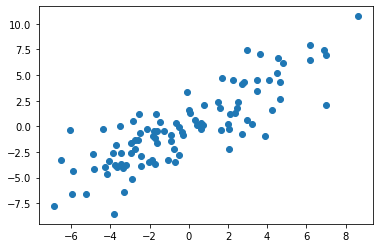

In [9]:
noise = add_multivariate_noise(np.zeros((100,2)), [[10,8],[8,10]])
plt.scatter(noise[:,0], noise[:,1])

## Sparse array functions

In [10]:
#export
def sparse_mul_col(arr, vector):
    '''multiplies matrix columns by vector'''
    m = scipy.sparse.csc_matrix(arr)
    m.data = m.data*np.take(vector, m.indices)
    return m

def sparse_mul_row(arr, vector):
    '''multiplies matrix rows by vector'''
    m = scipy.sparse.csr_matrix(arr)
    m.data = m.data*np.take(vector, m.indices)
    return m

## Neighbor functions

In [62]:
#export
#cossim query functions

def transform_similarity_weights(query_vector, query_space, beta = 1, gamma = 1):
    '''
    handles query vector and query space using stretch factors beta and gamma
    '''
    if not scipy.sparse.issparse(query_vector):
        query_vector = scipy.sparse.csr_matrix(query_vector)

    if not scipy.sparse.issparse(query_space):
        query_space = scipy.sparse.csr_matrix(query_space)

    if gamma == 1:
        query_space = normalize(query_space)
    elif gamma == 0:
        query_space.data = query_space.data**gamma
        query_space = normalize(query_space)
    else:
        #normalize, apply beta and normalize again
        query_space = normalize(query_space)
        query_space.data = query_space.data**gamma
        query_space = normalize(query_space)

    if beta == 1:
        query_vector = normalize(query_vector)
    elif beta == 0:
        query_vector.data = query_vector.data**beta
        query_vector = normalize(query_vector)
    else:
        #normalize, apply gamma and normalize again
        query_vector = normalize(query_vector)
        query_vector.data = query_vector.data**beta
        query_vector = normalize(query_vector)

    return query_vector, query_space

def sparse_dot_product(A, B, ntop, lower_bound):
    '''dot product of two saprse matrices'''
    return awesome_cossim_topn(A, B,ntop=ntop, lower_bound=lower_bound)

def make_batches(arr, batch_size = 100):
    '''make batches for batch query'''
    #lst = [i for i in arr]

    if arr.shape[0] < batch_size:
        batches = [arr]
    else:
        n_bs = arr.shape[0] // batch_size
        last_batch = arr.shape[0] - batch_size * n_bs
        batches = []
        i = 0
        for i in range(n_bs):
            batches.append(arr[i * batch_size:(i + 1) * batch_size])

        if last_batch:
            batches.append(arr[(i + 1) * batch_size:])
    return batches

def cos_sim_query(query_vector, query_space, n_neighbors=50, lower_bound=0.0, beta = 1, gamma = 1, multicore = False):
    '''make cos similarity query of query_vector on query_space
    beta is a weightening factor such that query_space = normalize(query_space^beta)
    beta greater than one ensure higher magnitude components recieves more importance when querying
    returns idx, sim
    '''

    query_vector, query_space = copy.deepcopy(query_vector), copy.deepcopy(query_space)
    query_vector, query_space = transform_similarity_weights(query_vector, query_space, beta, gamma)

    #print(f'n_dims = {query_space.shape[1]}, query_space_size = {query_space.shape[0]}, query_vector_size = {query_vector.shape[0]}')
    #print(f'Querying {n_neighbors} nearest neighbors, this can take a while...')

    query_space = query_space.T
    if not scipy.sparse.issparse(query_vector):
        query_vector = scipy.sparse.csr_matrix(query_vector)

    if not scipy.sparse.issparse(query_space):
        query_space = scipy.sparse.csr_matrix(query_space)
    try:
        if not multicore:
            sim_matrix = (
                awesome_cossim_topn(query_vector, query_space,ntop=n_neighbors, lower_bound=lower_bound)
            )
        else:
            batches = make_batches(query_vector)
            print
            sim_matrix = Parallel(n_jobs=-1, verbose=0,
                                   **_joblib_parallel_args(prefer="threads"))(
                    delayed(awesome_cossim_topn)(qv, query_space,
                                             ntop=n_neighbors, lower_bound=lower_bound)
                    for qv in tqdm(batches))
            sim_matrix = scipy.sparse.vstack(sim_matrix)

        sim_matrix = scipy.sparse.coo_matrix(sim_matrix)

        idx = []
        sim = []
        arr_sizes = []
        for row in range(sim_matrix.shape[0]):
            s = sim_matrix.data[sim_matrix.row == row]
            i = sim_matrix.col[sim_matrix.row == row]
            sim.append(s)
            idx.append(i)
            arr_sizes.append(len(s))

        max_size = max(arr_sizes)
        idx = np.array([pad_to_shape(i, max_size) for i in idx]).astype(int)
        sim = np.array([pad_to_shape(s, max_size) for i in sim])
        if idx.shape[1] == 0:
            raise ValueError('No similarity greater than lower_bound found. Choose a lower threshold.')
        return  idx, sim

    except NameError: #in case sparse_dot_topn is not instaled
        dist, idx = (
            NearestNeighbors(n_neighbors = n_neighbors, radius = 1 - lower_bound, metric = 'cosine', n_jobs = -1)
            .fit(query_space)
            .kneighbors(query_vector)
        )
        return idx, 1 - dist # <- cos_sim = 1 - cos_dist

## Dataset loading functions

In [12]:
#export
def sigmoid(x):
    return 1/(1+np.exp(x))

def make_bimodal_regression(n_samples, split_frac = 0.8, bimodal_inbalance = 0, random_state = None):
    '''make 2d bimodal regression dataset
    returns X_train, y_train, X_test, y_test
    '''

    X,y = make_regression(
        n_samples=10000,
        n_features=15,
        n_informative=6,
        n_targets=2,
        bias=500,
        effective_rank=None,
        tail_strength=2,
        noise=0.2,
        shuffle=True,
        coef=False,
        random_state = random_state
    )


    #make one of X[1] feature mode weightening
    bimodal_factors = (sigmoid(bimodal_inbalance*X[:,-1]) > np.random.random(size = X.shape[0])).astype(int)
    bimodal_factors[bimodal_factors == 0] = -1
    bimodal_factors = bimodal_factors.reshape(-1,1)

    y = bimodal_factors*y
    X_train, X_test = X[:int(split_frac*len(X))], X[int(split_frac*len(X)):]
    y_train, y_test = y[:int(split_frac*len(X))], y[int(split_frac*len(X)):]
    return X_train, y_train, X_test, y_test

## Data viz functions

In [13]:
#export
def make_distplot(sample,true_value,y_test,):

    if (len(sample.shape) > 1) and (sample.shape[-1] == 2):
        jntplot = sns.jointplot(sample[:,0], sample[:,1], joint_kws = {'label':'Model Samples', 'alpha':1})
        jntplot.ax_joint.scatter(y_test[:,0], y_test[:,1], color = 'orange', alpha = 0.01, label = 'Target Distribution')
        jntplot.ax_joint.scatter(true_value[0], true_value[1], color = 'red', label = 'Target Value')
        jntplot.ax_joint.legend()

    else:
        sns.distplot(sample, kde = True, bins = 20, hist_kws = {'label':'Model Samples'})
        dst = sns.distplot(y_test, kde = True, bins = 20, hist_kws = {'label':'Target Distribution'})
        dst._axes.axvline(true_value[0], color = 'r')
        dst._axes.legend()

# Helping Classes - 

In [14]:
#export
class DelegateEstimatorMixIn(object):
    '''
    class to make getattr method look for method in estimator object if not found in parent class.
    parent class should contain 'estimator' attribute
    '''
    estimator = None
    def __getattr__(self,attr):
        # if use try except, gets infinite recursion

        if (attr in dir(self)) or (attr in list(self.__dict__)):
            return object.__getattribute__(self, attr)
        elif (attr in dir(self.estimator)) or (attr in list(self.estimator.__dict__)) and (not self.estimator):
            return object.__getattribute__(self.estimator, attr)
        else:
            return object.__getattribute__(self, attr) #raise key error

# Export -

In [3]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01_ensemble.ipynb.
Converted 02_core.random_variable.ipynb.
Converted 03_utils.ipynb.
Converted 04_metrics.ipynb.
Converted 05_neighbors.ipynb.
Converted 06_kde_baesyan_nets.ipynb.
Converted index.ipynb.
